Ordinary Differential Equations: Conversion Reaction
============================

This example provides a model for the interconversion of two species 
($X_1$ and $X_2$) following first-order mass action kinetics with the 
parameters $\Theta_1$ and $\Theta_2$ respectively:


$$
    X_1 \rightarrow X_2, \quad\text{rate} = \Theta_1 \cdot [X_1]
$$

$$
    X_2 \rightarrow X_1, \quad\text{rate} = \Theta_2 \cdot [X_2]
$$

Measurement of $[X_2]$ is provided as $Y = [X_2]$.

We will show how to estimate $\Theta_1$ and $\Theta_2$ using pyABC.

In [1]:
%matplotlib inline

import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
import scipy as sp
import time

db_path = ("sqlite://")

In [2]:
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                               theta2=pyabc.RV("uniform", 0, 1))
parameter_prior.get_parameter_names()

eps_list=[5, 3, 2, 1, 0.75, 0.5, 0.33, 0.25]
#eps = pyabc.ListEpsilon(eps_list)
eps=pyabc.MedianEpsilon(500, median_multiplier=0.8)
pop_size = 500
noise_factor=0.025
iters=100
min_eps=0.2

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{\text{true}}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 

ODE model
---------

$$
    \begin{align*}
    \frac{dX_1}{dt} &= -\Theta_1 \cdot X_1 + \Theta_2 \cdot X_2\\
    \frac{dX_2}{dt} &= \Theta_1 \cdot X_1 - \Theta_2 \cdot X_2
    \end{align*}
$$

Define the true parameters

and the measurement data

In [3]:
theta1_true, theta2_true = np.exp([-2.5, -2])
measurement_data = np.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])

as well as the time points at which to evaluate

and the initial conditions for $X_1$ and $X_2$

In [4]:
measurement_times = np.arange(len(measurement_data))        
init = np.array([1, 0])

Define the ODE model

In [5]:
def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2



def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],pars["theta2"]))
    noise = noise_factor*np.random.normal(0,1,len(sol[:,1]))
    return {"X_2": sol[:,1]+noise}

Integration of the ODE model for the true parameter values

In [6]:
true_trajectory = model({"theta1": theta1_true,
                         "theta2": theta2_true})["X_2"]

Let's visualize the results

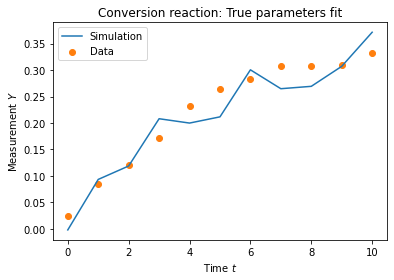

In [7]:
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In [8]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [9]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)
abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        transitions=pyabc.LocalTransition(k_fraction=.3),
        eps=eps)

histories=[]
runtimes=np.zeros(iters)
for i in range(iters):
    starttime=time.time()
    abc.new(db_path, {"X_2": measurement_data});
    endtime=time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    histories.append(h)
    runtimes[i]=endtime-starttime

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 13:58:14.075881, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8778608398277212.
INFO:ABC:Preliminary accepted: 490;  Preliminary acceptance rate: 490 / 1248 = 3.9263e-01
INFO:ABC:Acceptance rate: 500 / 1700 = 2.9412e-01, ESS=4.9225e+02.
INFO:ABC:t: 2, eps: 0.8290810942330791.
INFO:ABC:Preliminary accepted: 367;  Preliminary acceptance rate: 367 / 1176 = 3.1207e-01
INFO:ABC:Acceptance rate: 500 / 1786 = 2.7996e-01, ESS=4.8776e+02.
INFO:ABC:t: 3, eps: 0.517131218961365.
INFO:ABC:Preliminary accepted: 230;  Preliminary acceptance rate: 230 / 1265 = 1.8182e-01
INFO:ABC:Acceptance rate: 500 / 2866 = 1.7446e-01, ESS=4.7943e+02.
INFO:ABC:t: 4, eps: 0.34958728938600175.
INFO:ABC:Preliminary accepted: 226;  Preliminary acceptance rate: 226 / 1461 = 1.5469e-01
INFO:ABC:Acceptance rate: 500 / 3083 = 1.6218e-01, ESS=4.7700e+02.
INFO:ABC:t: 5, eps: 0.23574499004

INFO:ABC:Preliminary accepted: 349;  Preliminary acceptance rate: 349 / 1059 = 3.2956e-01
INFO:ABC:Acceptance rate: 500 / 1620 = 3.0864e-01, ESS=4.8055e+02.
INFO:ABC:t: 3, eps: 0.4957033439558578.
INFO:ABC:Preliminary accepted: 178;  Preliminary acceptance rate: 178 / 1111 = 1.6022e-01
INFO:ABC:Acceptance rate: 500 / 3095 = 1.6155e-01, ESS=4.7187e+02.
INFO:ABC:t: 4, eps: 0.33192630694390096.
INFO:ABC:Preliminary accepted: 172;  Preliminary acceptance rate: 172 / 1066 = 1.6135e-01
INFO:ABC:Acceptance rate: 500 / 3083 = 1.6218e-01, ESS=4.8249e+02.
INFO:ABC:t: 5, eps: 0.2258434299609725.
INFO:ABC:Preliminary accepted: 93;  Preliminary acceptance rate: 93 / 1190 = 7.8151e-02
INFO:ABC:Acceptance rate: 500 / 5612 = 8.9095e-02, ESS=4.3737e+02.
INFO:ABC:t: 6, eps: 0.16205992401890645.
INFO:ABC:Preliminary accepted: 15;  Preliminary acceptance rate: 15 / 1230 = 1.2195e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 25979 = 1.9246e-02, ESS=3.2821e+02.
INFO:pyabc.ut

INFO:ABC:Acceptance rate: 500 / 2984 = 1.6756e-01, ESS=4.9168e+02.
INFO:ABC:t: 5, eps: 0.23295003765569963.
INFO:ABC:Preliminary accepted: 149;  Preliminary acceptance rate: 149 / 1288 = 1.1568e-01
INFO:ABC:Acceptance rate: 500 / 4463 = 1.1203e-01, ESS=4.1429e+02.
INFO:ABC:t: 6, eps: 0.16752682475653174.
INFO:ABC:Preliminary accepted: 22;  Preliminary acceptance rate: 22 / 1180 = 1.8644e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 23430 = 2.1340e-02, ESS=3.7735e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:01:36.136069, end_time=2020-11-18 14:01:55.902815)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:01:55.913071, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7760324735684674.
INFO:ABC:Preliminary accepted: 441;  Preliminary acceptance rate: 441 / 1160 = 3.8017e-01
INFO:ABC:Acceptance rate: 500 / 16

INFO:ABC:Acceptance rate: 500 / 30002 = 1.6666e-02, ESS=3.7872e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:03:20.479610, end_time=2020-11-18 14:03:42.794608)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:03:42.804820, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9008403518943522.
INFO:ABC:Preliminary accepted: 430;  Preliminary acceptance rate: 430 / 1117 = 3.8496e-01
INFO:ABC:Acceptance rate: 500 / 1580 = 3.1646e-01, ESS=4.8372e+02.
INFO:ABC:t: 2, eps: 0.8104203802623952.
INFO:ABC:Preliminary accepted: 418;  Preliminary acceptance rate: 418 / 1305 = 3.2031e-01
INFO:ABC:Acceptance rate: 500 / 1924 = 2.5988e-01, ESS=4.8727e+02.
INFO:ABC:t: 3, eps: 0.5045269362510132.
INFO:ABC:Preliminary accepted: 198;  Preliminary acceptance rate: 198 / 1232 = 1.6071e-01
INFO:ABC:Acceptance rate: 500 / 3042 = 1.6437e-01, ESS=4.7174e+02.
INFO:ABC:t

INFO:ABC:Preliminary accepted: 422;  Preliminary acceptance rate: 422 / 1067 = 3.9550e-01
INFO:ABC:Acceptance rate: 500 / 1563 = 3.1990e-01, ESS=4.8723e+02.
INFO:ABC:t: 2, eps: 0.8356829753645333.
INFO:ABC:Preliminary accepted: 428;  Preliminary acceptance rate: 428 / 1221 = 3.5053e-01
INFO:ABC:Acceptance rate: 500 / 1699 = 2.9429e-01, ESS=4.7184e+02.
INFO:ABC:t: 3, eps: 0.5040212151402501.
INFO:ABC:Preliminary accepted: 171;  Preliminary acceptance rate: 171 / 1122 = 1.5241e-01
INFO:ABC:Acceptance rate: 500 / 3161 = 1.5818e-01, ESS=4.8503e+02.
INFO:ABC:t: 4, eps: 0.33932107126003.
INFO:ABC:Preliminary accepted: 181;  Preliminary acceptance rate: 181 / 1071 = 1.6900e-01
INFO:ABC:Acceptance rate: 500 / 2999 = 1.6672e-01, ESS=4.8629e+02.
INFO:ABC:t: 5, eps: 0.22868888364731005.
INFO:ABC:Preliminary accepted: 97;  Preliminary acceptance rate: 97 / 1150 = 8.4348e-02
INFO:ABC:Acceptance rate: 500 / 5644 = 8.8590e-02, ESS=4.4731e+02.
INFO:ABC:t: 6, eps: 0.16468320741537001.
INFO:ABC:Prelimin

INFO:ABC:Acceptance rate: 500 / 3113 = 1.6062e-01, ESS=4.7095e+02.
INFO:ABC:t: 4, eps: 0.32562164626320156.
INFO:ABC:Preliminary accepted: 172;  Preliminary acceptance rate: 172 / 1125 = 1.5289e-01
INFO:ABC:Acceptance rate: 500 / 3161 = 1.5818e-01, ESS=4.7620e+02.
INFO:ABC:t: 5, eps: 0.22468250659529249.
INFO:ABC:Preliminary accepted: 98;  Preliminary acceptance rate: 98 / 1115 = 8.7892e-02
INFO:ABC:Acceptance rate: 500 / 5278 = 9.4733e-02, ESS=3.4264e+02.
INFO:ABC:t: 6, eps: 0.16215400099944885.
INFO:ABC:Preliminary accepted: 35;  Preliminary acceptance rate: 35 / 1138 = 3.0756e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 25588 = 1.9540e-02, ESS=3.5843e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:07:29.640728, end_time=2020-11-18 14:07:51.554078)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:07:51.566028, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 50

INFO:ABC:Acceptance rate: 500 / 4874 = 1.0259e-01, ESS=4.7225e+02.
INFO:ABC:t: 6, eps: 0.17006519150209518.
INFO:ABC:Preliminary accepted: 23;  Preliminary acceptance rate: 23 / 1254 = 1.8341e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 19138 = 2.6126e-02, ESS=4.1121e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:09:23.092238, end_time=2020-11-18 14:09:42.613227)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:09:42.623650, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7498215675212785.
INFO:ABC:Preliminary accepted: 437;  Preliminary acceptance rate: 437 / 1123 = 3.8914e-01
INFO:ABC:Acceptance rate: 500 / 1563 = 3.1990e-01, ESS=4.7748e+02.
INFO:ABC:t: 2, eps: 0.7570659314864264.
INFO:ABC:Preliminary accepted: 440;  Preliminary acceptance rate: 440 / 1259 = 3.4948e-01
INFO:ABC:Acceptance rate: 500 / 183

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:11:41.231291, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.951455431869028.
INFO:ABC:Preliminary accepted: 360;  Preliminary acceptance rate: 360 / 958 = 3.7578e-01
INFO:ABC:Acceptance rate: 500 / 1439 = 3.4746e-01, ESS=4.7928e+02.
INFO:ABC:t: 2, eps: 0.8695988263029686.
INFO:ABC:Preliminary accepted: 460;  Preliminary acceptance rate: 460 / 1225 = 3.7551e-01
INFO:ABC:Acceptance rate: 500 / 1692 = 2.9551e-01, ESS=4.7699e+02.
INFO:ABC:t: 3, eps: 0.5152021389075773.
INFO:ABC:Preliminary accepted: 225;  Preliminary acceptance rate: 225 / 1335 = 1.6854e-01
INFO:ABC:Acceptance rate: 500 / 3184 = 1.5704e-01, ESS=4.5645e+02.
INFO:ABC:t: 4, eps: 0.34919569649995275.
INFO:ABC:Preliminary accepted: 180;  Preliminary acceptance rate: 180 / 1245 = 1.4458e-01
INFO:ABC:Acceptance rate: 500 / 3413 = 1.4650e-01, ESS=4.7900e+02.
INFO:ABC:t: 5, eps: 0.239061605474

INFO:ABC:Acceptance rate: 500 / 1854 = 2.6969e-01, ESS=4.7714e+02.
INFO:ABC:t: 3, eps: 0.4825165645517065.
INFO:ABC:Preliminary accepted: 231;  Preliminary acceptance rate: 231 / 1232 = 1.8750e-01
INFO:ABC:Acceptance rate: 500 / 2912 = 1.7170e-01, ESS=4.7648e+02.
INFO:ABC:t: 4, eps: 0.3233034799349928.
INFO:ABC:Preliminary accepted: 187;  Preliminary acceptance rate: 187 / 1055 = 1.7725e-01
INFO:ABC:Acceptance rate: 500 / 2887 = 1.7319e-01, ESS=4.8287e+02.
INFO:ABC:t: 5, eps: 0.22136474638127224.
INFO:ABC:Preliminary accepted: 102;  Preliminary acceptance rate: 102 / 1057 = 9.6500e-02
INFO:ABC:Acceptance rate: 500 / 5759 = 8.6821e-02, ESS=4.6374e+02.
INFO:ABC:t: 6, eps: 0.1578399050552357.
INFO:ABC:Preliminary accepted: 22;  Preliminary acceptance rate: 22 / 1213 = 1.8137e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 31376 = 1.5936e-02, ESS=3.2883e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:13

INFO:ABC:t: 5, eps: 0.2391923337608195.
INFO:ABC:Preliminary accepted: 117;  Preliminary acceptance rate: 117 / 1027 = 1.1392e-01
INFO:ABC:Acceptance rate: 500 / 4646 = 1.0762e-01, ESS=4.4364e+02.
INFO:ABC:t: 6, eps: 0.17015694629137743.
INFO:ABC:Preliminary accepted: 29;  Preliminary acceptance rate: 29 / 1435 = 2.0209e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 20570 = 2.4307e-02, ESS=3.7055e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:15:28.052162, end_time=2020-11-18 14:15:47.191912)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:15:47.202731, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8221251088287318.
INFO:ABC:Preliminary accepted: 444;  Preliminary acceptance rate: 444 / 1219 = 3.6423e-01
INFO:ABC:Acceptance rate: 500 / 1754 = 2.8506e-01, ESS=4.8432e+02.
INFO:ABC:t: 2, eps: 0.8298162704942

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:17:19.841765, end_time=2020-11-18 14:17:42.702576)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:17:42.712165, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 504 = 9.9206e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7274515150860386.
INFO:ABC:Preliminary accepted: 402;  Preliminary acceptance rate: 402 / 974 = 4.1273e-01
INFO:ABC:Acceptance rate: 500 / 1534 = 3.2595e-01, ESS=4.8326e+02.
INFO:ABC:t: 2, eps: 0.7648800049312818.
INFO:ABC:Preliminary accepted: 385;  Preliminary acceptance rate: 385 / 1139 = 3.3802e-01
INFO:ABC:Acceptance rate: 500 / 1676 = 2.9833e-01, ESS=4.8956e+02.
INFO:ABC:t: 3, eps: 0.4830356777649816.
INFO:ABC:Preliminary accepted: 188;  Preliminary acceptance rate: 188 / 1220 = 1.5410e-01
INFO:ABC:Acceptance rate: 500 / 3331 = 1.5011e-01, ESS=4.4069e+02.
INFO:ABC:t: 4, eps: 0.3149013232981033.
INFO:ABC:Preliminary accepted: 147;  Pr

INFO:ABC:Acceptance rate: 500 / 1521 = 3.2873e-01, ESS=4.7582e+02.
INFO:ABC:t: 2, eps: 0.827251061331701.
INFO:ABC:Preliminary accepted: 380;  Preliminary acceptance rate: 380 / 1064 = 3.5714e-01
INFO:ABC:Acceptance rate: 500 / 1609 = 3.1075e-01, ESS=4.9035e+02.
INFO:ABC:t: 3, eps: 0.5112084550304757.
INFO:ABC:Preliminary accepted: 180;  Preliminary acceptance rate: 180 / 1188 = 1.5152e-01
INFO:ABC:Acceptance rate: 500 / 3030 = 1.6502e-01, ESS=4.5365e+02.
INFO:ABC:t: 4, eps: 0.3414904497473741.
INFO:ABC:Preliminary accepted: 205;  Preliminary acceptance rate: 205 / 1065 = 1.9249e-01
INFO:ABC:Acceptance rate: 500 / 2922 = 1.7112e-01, ESS=4.7301e+02.
INFO:ABC:t: 5, eps: 0.23122125876179453.
INFO:ABC:Preliminary accepted: 123;  Preliminary acceptance rate: 123 / 1240 = 9.9194e-02
INFO:ABC:Acceptance rate: 500 / 5031 = 9.9384e-02, ESS=4.2566e+02.
INFO:ABC:t: 6, eps: 0.16592307848478172.
INFO:ABC:Preliminary accepted: 34;  Preliminary acceptance rate: 34 / 1151 = 2.9540e-02
INFO:pyabc.util:

INFO:ABC:t: 4, eps: 0.3145223808382472.
INFO:ABC:Preliminary accepted: 204;  Preliminary acceptance rate: 204 / 1398 = 1.4592e-01
INFO:ABC:Acceptance rate: 500 / 3684 = 1.3572e-01, ESS=4.7996e+02.
INFO:ABC:t: 5, eps: 0.21803909036865798.
INFO:ABC:Preliminary accepted: 109;  Preliminary acceptance rate: 109 / 1325 = 8.2264e-02
INFO:ABC:Acceptance rate: 500 / 6142 = 8.1407e-02, ESS=3.1813e+02.
INFO:ABC:t: 6, eps: 0.1574330470106758.
INFO:ABC:Preliminary accepted: 21;  Preliminary acceptance rate: 21 / 1191 = 1.7632e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 34071 = 1.4675e-02, ESS=3.6907e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:21:32.326503, end_time=2020-11-18 14:21:57.978337)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:21:57.987939, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8398728228623

INFO:ABC:Preliminary accepted: 29;  Preliminary acceptance rate: 29 / 1185 = 2.4473e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 21931 = 2.2799e-02, ESS=3.9936e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:23:37.139085, end_time=2020-11-18 14:23:56.906957)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:23:56.914802, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8142827687020138.
INFO:ABC:Preliminary accepted: 478;  Preliminary acceptance rate: 478 / 1173 = 4.0750e-01
INFO:ABC:Acceptance rate: 500 / 1632 = 3.0637e-01, ESS=4.7892e+02.
INFO:ABC:t: 2, eps: 0.7908853844770576.
INFO:ABC:Preliminary accepted: 468;  Preliminary acceptance rate: 468 / 1369 = 3.4186e-01
INFO:ABC:Acceptance rate: 500 / 1943 = 2.5733e-01, ESS=4.8799e+02.
INFO:ABC:t: 3, eps: 0.49333459944919034.
INFO:ABC:Preliminary accepted: 183;

INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8763341138008514.
INFO:ABC:Preliminary accepted: 437;  Preliminary acceptance rate: 437 / 1066 = 4.0994e-01
INFO:ABC:Acceptance rate: 500 / 1504 = 3.3245e-01, ESS=4.7818e+02.
INFO:ABC:t: 2, eps: 0.8135091359528662.
INFO:ABC:Preliminary accepted: 433;  Preliminary acceptance rate: 433 / 1283 = 3.3749e-01
INFO:ABC:Acceptance rate: 500 / 1864 = 2.6824e-01, ESS=4.7418e+02.
INFO:ABC:t: 3, eps: 0.49804866520770696.
INFO:ABC:Preliminary accepted: 177;  Preliminary acceptance rate: 177 / 1180 = 1.5000e-01
INFO:ABC:Acceptance rate: 500 / 3516 = 1.4221e-01, ESS=4.7313e+02.
INFO:ABC:t: 4, eps: 0.3382680351864861.
INFO:ABC:Preliminary accepted: 207;  Preliminary acceptance rate: 207 / 1284 = 1.6121e-01
INFO:ABC:Acceptance rate: 500 / 3032 = 1.6491e-01, ESS=4.4802e+02.
INFO:ABC:t: 5, eps: 0.22907253957989837.
INFO:ABC:Preliminary accepted: 108;  Preliminary acceptance rate: 108 / 1265 = 

INFO:ABC:Acceptance rate: 500 / 1607 = 3.1114e-01, ESS=4.4965e+02.
INFO:ABC:t: 3, eps: 0.49770795435171494.
INFO:ABC:Preliminary accepted: 210;  Preliminary acceptance rate: 210 / 1196 = 1.7559e-01
INFO:ABC:Acceptance rate: 500 / 2879 = 1.7367e-01, ESS=4.7966e+02.
INFO:ABC:t: 4, eps: 0.3344017350681758.
INFO:ABC:Preliminary accepted: 169;  Preliminary acceptance rate: 169 / 1021 = 1.6552e-01
INFO:ABC:Acceptance rate: 500 / 2975 = 1.6807e-01, ESS=4.6148e+02.
INFO:ABC:t: 5, eps: 0.22311603992137563.
INFO:ABC:Preliminary accepted: 103;  Preliminary acceptance rate: 103 / 1307 = 7.8806e-02
INFO:ABC:Acceptance rate: 500 / 6122 = 8.1673e-02, ESS=4.2374e+02.
INFO:ABC:t: 6, eps: 0.15911942260777567.
INFO:ABC:Preliminary accepted: 14;  Preliminary acceptance rate: 14 / 1218 = 1.1494e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 34967 = 1.4299e-02, ESS=3.7300e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:

INFO:ABC:Acceptance rate: 500 / 3158 = 1.5833e-01, ESS=4.7996e+02.
INFO:ABC:t: 5, eps: 0.2416099552230569.
INFO:ABC:Preliminary accepted: 113;  Preliminary acceptance rate: 113 / 1073 = 1.0531e-01
INFO:ABC:Acceptance rate: 500 / 4487 = 1.1143e-01, ESS=4.5418e+02.
INFO:ABC:t: 6, eps: 0.17326761754103062.
INFO:ABC:Preliminary accepted: 35;  Preliminary acceptance rate: 35 / 1208 = 2.8974e-02
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 18731 = 2.6694e-02, ESS=4.1910e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:29:43.323171, end_time=2020-11-18 14:30:02.762778)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:30:02.774456, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9009619475555142.
INFO:ABC:Preliminary accepted: 394;  Preliminary acceptance rate: 394 / 1020 = 3.8627e-01
INFO:ABC:Acceptance rate: 500 / 148

INFO:ABC:Acceptance rate: 500 / 31811 = 1.5718e-02, ESS=3.8458e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:31:32.596296, end_time=2020-11-18 14:31:57.418383)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:31:57.428238, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8125010141194626.
INFO:ABC:Preliminary accepted: 384;  Preliminary acceptance rate: 384 / 1038 = 3.6994e-01
INFO:ABC:Acceptance rate: 500 / 1538 = 3.2510e-01, ESS=4.9074e+02.
INFO:ABC:t: 2, eps: 0.7515065066894868.
INFO:ABC:Preliminary accepted: 388;  Preliminary acceptance rate: 388 / 1148 = 3.3798e-01
INFO:ABC:Acceptance rate: 500 / 1693 = 2.9533e-01, ESS=4.7997e+02.
INFO:ABC:t: 3, eps: 0.4774481839765232.
INFO:ABC:Preliminary accepted: 211;  Preliminary acceptance rate: 211 / 1387 = 1.5213e-01
INFO:ABC:Acceptance rate: 500 / 3303 = 1.5138e-01, ESS=4.5348e+02.
INFO:ABC:t

INFO:ABC:Preliminary accepted: 386;  Preliminary acceptance rate: 386 / 1050 = 3.6762e-01
INFO:ABC:Acceptance rate: 500 / 1535 = 3.2573e-01, ESS=4.8495e+02.
INFO:ABC:t: 2, eps: 0.9025811164526193.
INFO:ABC:Preliminary accepted: 455;  Preliminary acceptance rate: 455 / 1295 = 3.5135e-01
INFO:ABC:Acceptance rate: 500 / 1828 = 2.7352e-01, ESS=4.8224e+02.
INFO:ABC:t: 3, eps: 0.537042983243592.
INFO:ABC:Preliminary accepted: 214;  Preliminary acceptance rate: 214 / 1089 = 1.9651e-01
INFO:ABC:Acceptance rate: 500 / 2610 = 1.9157e-01, ESS=4.7425e+02.
INFO:ABC:t: 4, eps: 0.3606474602121652.
INFO:ABC:Preliminary accepted: 208;  Preliminary acceptance rate: 208 / 1242 = 1.6747e-01
INFO:ABC:Acceptance rate: 500 / 2958 = 1.6903e-01, ESS=4.5536e+02.
INFO:ABC:t: 5, eps: 0.241892496561379.
INFO:ABC:Preliminary accepted: 136;  Preliminary acceptance rate: 136 / 1284 = 1.0592e-01
INFO:ABC:Acceptance rate: 500 / 5128 = 9.7504e-02, ESS=4.4364e+02.
INFO:ABC:t: 6, eps: 0.17282051775176924.
INFO:ABC:Prelimi

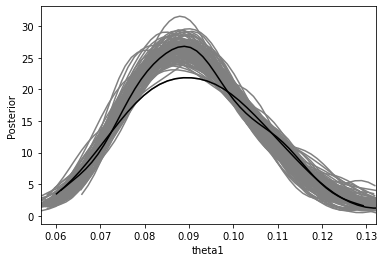

In [10]:
tmax=histories[0].max_t
fig,ax = plt.subplots()
highest=0
highest_index=0
lowest=1
lowest_index=0
for i in range(iters):
    df,w = histories[i].get_distribution(m=0,t=histories[i].max_t)
    pyabc.visualization.plot_kde_1d(df, w, x='theta1',ax=ax, color='grey')
    
    if w.max() >= highest:
        highest = w.max()
        highest_index = i
    if w.max() <= lowest:
        lowest = w.max()
        lowest_index = i

df_h, w_h = histories[highest_index].get_distribution(m=0,t=histories[highest_index].max_t)
pyabc.visualization.plot_kde_1d(df_h, w_h, x='theta1',ax=ax, color='black')

df_l, w_l = histories[lowest_index].get_distribution(m=0,t=histories[lowest_index].max_t)
pyabc.visualization.plot_kde_1d(df_l, w_l, x='theta1',ax=ax, color='black')

In [11]:
theta1_means = np.zeros(iters)
theta1_stds = np.zeros(iters)

theta2_means = np.zeros(iters)
theta2_stds = np.zeros(iters)

effective_sample_size=np.zeros(iters)

for i in range(iters):
    
    df,w= histories[i].get_distribution(m=0,t=histories[i].max_t)
    
    points = df['theta1'].values
    theta1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    theta1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    points = df['theta2'].values
    theta2_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    theta2_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    effective_sample_size[i]=pyabc.weighted_statistics.effective_sample_size(w)

allnames=[]
allnames.append("theta1_means")
allnames.append("theta2_means")
allnames.append("theta1_stds")
allnames.append("theta2_stds")
allnames.append("effective_sample_size")

alldata = []
for i in range(len(allnames)):
    alldata.append(eval(allnames[i]))

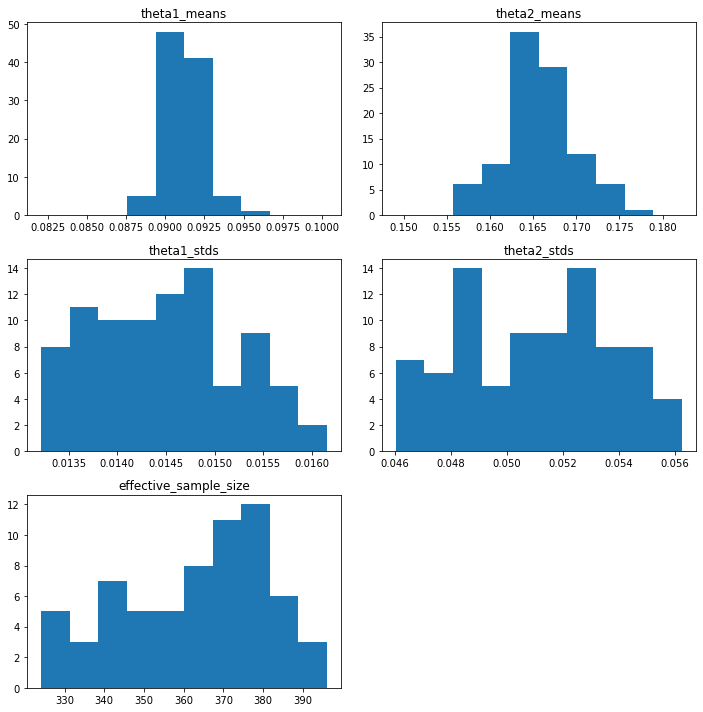

In [12]:
fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata[i], bins = 10, range=(0.9*alldata[i].mean(), 1.1*alldata[i].mean()))
    ax.set_title(allnames[i])
    
fig.tight_layout()


In [13]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = False)
abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        transitions=pyabc.LocalTransition(k_fraction=.3),
        eps=eps)

histories_ori=[]
runtimes_ori=np.zeros(iters)
for i in range(iters):
    starttime=time.time()
    abc.new(db_path, {"X_2": measurement_data});
    endtime=time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    histories_ori.append(h)
    runtimes[i]=endtime-starttime

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:35:55.612721, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8572174357984652.
INFO:ABC:Acceptance rate: 500 / 1338 = 3.7369e-01, ESS=4.8585e+02.
INFO:ABC:t: 2, eps: 0.8174133048177504.
INFO:ABC:Acceptance rate: 500 / 1483 = 3.3715e-01, ESS=4.6894e+02.
INFO:ABC:t: 3, eps: 0.49779009591828677.
INFO:ABC:Acceptance rate: 500 / 2823 = 1.7712e-01, ESS=4.8234e+02.
INFO:ABC:t: 4, eps: 0.3371490267763801.
INFO:ABC:Acceptance rate: 500 / 3074 = 1.6265e-01, ESS=4.8503e+02.
INFO:ABC:t: 5, eps: 0.2306519050876147.
INFO:ABC:Acceptance rate: 500 / 5040 = 9.9206e-02, ESS=4.4614e+02.
INFO:ABC:t: 6, eps: 0.16494330714439742.
INFO:ABC:Acceptance rate: 500 / 24839 = 2.0130e-02, ESS=3.6153e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:35:55.612721, end_time=2020-11-18 14:36:16.624134)>
INFO:History:Start <ABCS

INFO:ABC:t: 3, eps: 0.49051308593874376.
INFO:ABC:Acceptance rate: 500 / 3048 = 1.6404e-01, ESS=4.7603e+02.
INFO:ABC:t: 4, eps: 0.32539383661445576.
INFO:ABC:Acceptance rate: 500 / 3292 = 1.5188e-01, ESS=4.7639e+02.
INFO:ABC:t: 5, eps: 0.22255364142461542.
INFO:ABC:Acceptance rate: 500 / 6452 = 7.7495e-02, ESS=3.9160e+02.
INFO:ABC:t: 6, eps: 0.1599855136054405.
INFO:ABC:Acceptance rate: 500 / 30186 = 1.6564e-02, ESS=2.8872e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:38:48.317114, end_time=2020-11-18 14:39:11.565332)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:39:11.576856, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.860178112392954.
INFO:ABC:Acceptance rate: 500 / 1252 = 3.9936e-01, ESS=4.8289e+02.
INFO:ABC:t: 2, eps: 0.8090345411430436.
INFO:ABC:Acceptance rate: 500 / 1472 = 3.3967e-01, ESS=4.9226e+02.
INFO:ABC:t: 3, eps: 0.49

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:41:49.949272, end_time=2020-11-18 14:42:09.456732)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:42:09.467366, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8505078367216232.
INFO:ABC:Acceptance rate: 500 / 1290 = 3.8760e-01, ESS=4.7400e+02.
INFO:ABC:t: 2, eps: 0.7950435356949797.
INFO:ABC:Acceptance rate: 500 / 1531 = 3.2658e-01, ESS=4.5273e+02.
INFO:ABC:t: 3, eps: 0.5067791857170859.
INFO:ABC:Acceptance rate: 500 / 3265 = 1.5314e-01, ESS=4.7606e+02.
INFO:ABC:t: 4, eps: 0.3383202961506431.
INFO:ABC:Acceptance rate: 500 / 3400 = 1.4706e-01, ESS=4.8542e+02.
INFO:ABC:t: 5, eps: 0.23006220462166885.
INFO:ABC:Acceptance rate: 500 / 5281 = 9.4679e-02, ESS=4.5514e+02.
INFO:ABC:t: 6, eps: 0.16395216281933112.
INFO:ABC:Acceptance rate: 500 / 26129 = 1.9136e-02, ESS=3.5766e+02.
INFO:pyabc.util:Stopping

INFO:ABC:t: 2, eps: 0.8038097164841116.
INFO:ABC:Acceptance rate: 500 / 1519 = 3.2916e-01, ESS=4.9035e+02.
INFO:ABC:t: 3, eps: 0.49364463992210394.
INFO:ABC:Acceptance rate: 500 / 3171 = 1.5768e-01, ESS=4.7381e+02.
INFO:ABC:t: 4, eps: 0.33386658631120814.
INFO:ABC:Acceptance rate: 500 / 3392 = 1.4741e-01, ESS=4.7717e+02.
INFO:ABC:t: 5, eps: 0.2234218133020478.
INFO:ABC:Acceptance rate: 500 / 6015 = 8.3126e-02, ESS=4.5913e+02.
INFO:ABC:t: 6, eps: 0.1611753932541916.
INFO:ABC:Acceptance rate: 500 / 28972 = 1.7258e-02, ESS=3.1710e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:45:06.069205, end_time=2020-11-18 14:45:28.556377)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:45:28.566624, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7858375877359045.
INFO:ABC:Acceptance rate: 500 / 1262 = 3.9620e-01, ESS=4.8541e+02.
INFO:ABC:t: 2, eps: 0.77

INFO:ABC:t: 6, eps: 0.16133528945236278.
INFO:ABC:Acceptance rate: 500 / 27772 = 1.8004e-02, ESS=3.8175e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:48:04.123016, end_time=2020-11-18 14:48:26.255244)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:48:26.267130, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9514226286085568.
INFO:ABC:Acceptance rate: 500 / 1276 = 3.9185e-01, ESS=4.8077e+02.
INFO:ABC:t: 2, eps: 0.7813363810806787.
INFO:ABC:Acceptance rate: 500 / 1542 = 3.2425e-01, ESS=4.5566e+02.
INFO:ABC:t: 3, eps: 0.49429651181056383.
INFO:ABC:Acceptance rate: 500 / 3155 = 1.5848e-01, ESS=4.6337e+02.
INFO:ABC:t: 4, eps: 0.32661101581915264.
INFO:ABC:Acceptance rate: 500 / 3144 = 1.5903e-01, ESS=4.8826e+02.
INFO:ABC:t: 5, eps: 0.2238938707813879.
INFO:ABC:Acceptance rate: 500 / 5809 = 8.6073e-02, ESS=4.5542e+02.
INFO:ABC:t: 6, eps: 0.1

INFO:ABC:t: 1, eps: 1.9173840385962362.
INFO:ABC:Acceptance rate: 500 / 1288 = 3.8820e-01, ESS=4.8789e+02.
INFO:ABC:t: 2, eps: 0.8273689220785798.
INFO:ABC:Acceptance rate: 500 / 1373 = 3.6417e-01, ESS=4.8043e+02.
INFO:ABC:t: 3, eps: 0.508375301683486.
INFO:ABC:Acceptance rate: 500 / 2801 = 1.7851e-01, ESS=4.5683e+02.
INFO:ABC:t: 4, eps: 0.34011211616788584.
INFO:ABC:Acceptance rate: 500 / 3002 = 1.6656e-01, ESS=4.8182e+02.
INFO:ABC:t: 5, eps: 0.2273078855633832.
INFO:ABC:Acceptance rate: 500 / 5807 = 8.6103e-02, ESS=4.6830e+02.
INFO:ABC:t: 6, eps: 0.1633611268521169.
INFO:ABC:Acceptance rate: 500 / 27750 = 1.8018e-02, ESS=4.0431e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:51:21.664191, end_time=2020-11-18 14:51:43.636876)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:51:43.647061, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9558

INFO:ABC:t: 5, eps: 0.2211657498367539.
INFO:ABC:Acceptance rate: 500 / 6550 = 7.6336e-02, ESS=4.6638e+02.
INFO:ABC:t: 6, eps: 0.15968414817884313.
INFO:ABC:Acceptance rate: 500 / 34294 = 1.4580e-02, ESS=4.1335e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:54:21.957258, end_time=2020-11-18 14:54:46.466738)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:54:46.476757, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8956514723698323.
INFO:ABC:Acceptance rate: 500 / 1279 = 3.9093e-01, ESS=4.8044e+02.
INFO:ABC:t: 2, eps: 0.828029366658956.
INFO:ABC:Acceptance rate: 500 / 1382 = 3.6179e-01, ESS=4.8224e+02.
INFO:ABC:t: 3, eps: 0.5024031063899422.
INFO:ABC:Acceptance rate: 500 / 3381 = 1.4789e-01, ESS=4.7406e+02.
INFO:ABC:t: 4, eps: 0.33459051808519136.
INFO:ABC:Acceptance rate: 500 / 2642 = 1.8925e-01, ESS=4.8017e+02.
INFO:ABC:t: 5, eps: 0.230

INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7997195365509548.
INFO:ABC:Acceptance rate: 500 / 1351 = 3.7010e-01, ESS=4.8551e+02.
INFO:ABC:t: 2, eps: 0.7960550793631413.
INFO:ABC:Acceptance rate: 500 / 1462 = 3.4200e-01, ESS=4.7463e+02.
INFO:ABC:t: 3, eps: 0.5001730295257296.
INFO:ABC:Acceptance rate: 500 / 3299 = 1.5156e-01, ESS=4.4896e+02.
INFO:ABC:t: 4, eps: 0.3361043591283639.
INFO:ABC:Acceptance rate: 500 / 3098 = 1.6139e-01, ESS=4.9054e+02.
INFO:ABC:t: 5, eps: 0.2313080413392017.
INFO:ABC:Acceptance rate: 500 / 4912 = 1.0179e-01, ESS=4.3220e+02.
INFO:ABC:t: 6, eps: 0.16734121282834225.
INFO:ABC:Acceptance rate: 500 / 22320 = 2.2401e-02, ESS=3.1663e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 14:57:34.115956, end_time=2020-11-18 14:57:54.178073)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 14:57:54.191819, end_time=None)>
INFO:ABC:t: 0, eps: 500.


INFO:ABC:t: 4, eps: 0.3186123695109446.
INFO:ABC:Acceptance rate: 500 / 3298 = 1.5161e-01, ESS=4.7675e+02.
INFO:ABC:t: 5, eps: 0.21864915692459427.
INFO:ABC:Acceptance rate: 500 / 6332 = 7.8964e-02, ESS=4.5426e+02.
INFO:ABC:t: 6, eps: 0.15737396558845457.
INFO:ABC:Acceptance rate: 500 / 32151 = 1.5552e-02, ESS=3.6259e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 15:00:15.858289, end_time=2020-11-18 15:00:39.400753)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 15:00:39.411629, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.773073102047536.
INFO:ABC:Acceptance rate: 500 / 1260 = 3.9683e-01, ESS=4.8354e+02.
INFO:ABC:t: 2, eps: 0.8312313582878605.
INFO:ABC:Acceptance rate: 500 / 1436 = 3.4819e-01, ESS=4.8751e+02.
INFO:ABC:t: 3, eps: 0.5059359399038043.
INFO:ABC:Acceptance rate: 500 / 3266 = 1.5309e-01, ESS=4.6185e+02.
INFO:ABC:t: 4, eps: 0.336

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 15:03:27.642021, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.946080943913934.
INFO:ABC:Acceptance rate: 500 / 1349 = 3.7064e-01, ESS=4.7447e+02.
INFO:ABC:t: 2, eps: 0.8386641611325185.
INFO:ABC:Acceptance rate: 500 / 1413 = 3.5386e-01, ESS=4.7175e+02.
INFO:ABC:t: 3, eps: 0.5136031831263397.
INFO:ABC:Acceptance rate: 500 / 3148 = 1.5883e-01, ESS=4.5358e+02.
INFO:ABC:t: 4, eps: 0.3365122310234865.
INFO:ABC:Acceptance rate: 500 / 2884 = 1.7337e-01, ESS=4.7855e+02.
INFO:ABC:t: 5, eps: 0.22577104048739818.
INFO:ABC:Acceptance rate: 500 / 6077 = 8.2277e-02, ESS=4.6138e+02.
INFO:ABC:t: 6, eps: 0.162919458174159.
INFO:ABC:Acceptance rate: 500 / 26663 = 1.8753e-02, ESS=3.3601e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 15:03:27.642021, end_time=2020-11-18 15:03:49.534227)>
INFO:History:Start <ABCSMC(

INFO:ABC:Acceptance rate: 500 / 2870 = 1.7422e-01, ESS=4.8395e+02.
INFO:ABC:t: 4, eps: 0.3263813505571511.
INFO:ABC:Acceptance rate: 500 / 2810 = 1.7794e-01, ESS=4.8839e+02.
INFO:ABC:t: 5, eps: 0.22224765577619784.
INFO:ABC:Acceptance rate: 500 / 5827 = 8.5807e-02, ESS=4.2689e+02.
INFO:ABC:t: 6, eps: 0.16006319741103903.
INFO:ABC:Acceptance rate: 500 / 31834 = 1.5706e-02, ESS=3.9246e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 15:06:31.182021, end_time=2020-11-18 15:06:54.754365)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 15:06:54.765315, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8902255881838306.
INFO:ABC:Acceptance rate: 500 / 1267 = 3.9463e-01, ESS=4.7792e+02.
INFO:ABC:t: 2, eps: 0.8069494113449667.
INFO:ABC:Acceptance rate: 500 / 1477 = 3.3852e-01, ESS=4.5370e+02.
INFO:ABC:t: 3, eps: 0.49779754693404393.
INFO:ABC:Acceptance rat

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-18 15:09:32.847583, end_time=2020-11-18 15:09:56.779927)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-18 15:09:56.791855, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8839923532590448.
INFO:ABC:Acceptance rate: 500 / 1221 = 4.0950e-01, ESS=4.8601e+02.
INFO:ABC:t: 2, eps: 0.8083123210286962.
INFO:ABC:Acceptance rate: 500 / 1549 = 3.2279e-01, ESS=4.7171e+02.
INFO:ABC:t: 3, eps: 0.5026336806823335.
INFO:ABC:Acceptance rate: 500 / 3233 = 1.5466e-01, ESS=4.4083e+02.
INFO:ABC:t: 4, eps: 0.33529496755609733.
INFO:ABC:Acceptance rate: 500 / 3316 = 1.5078e-01, ESS=4.8228e+02.
INFO:ABC:t: 5, eps: 0.2298625199150356.
INFO:ABC:Acceptance rate: 500 / 4664 = 1.0720e-01, ESS=4.5267e+02.
INFO:ABC:t: 6, eps: 0.1648174833468431.
INFO:ABC:Acceptance rate: 500 / 27066 = 1.8473e-02, ESS=3.0966e+02.
INFO:pyabc.util:Stopping:

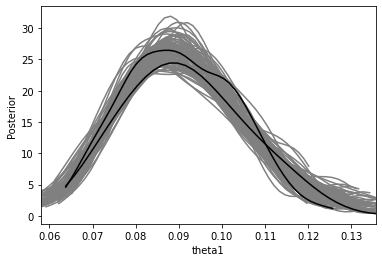

In [14]:
tmax=histories_ori[0].max_t
fig,ax = plt.subplots()
highest=0
highest_index=0
lowest=1
lowest_index=0
for i in range(iters):
    df,w = histories_ori[i].get_distribution(m=0,t=histories_ori[i].max_t)
    pyabc.visualization.plot_kde_1d(df, w, x='theta1',ax=ax, color='grey')
    
    if w.max() >= highest:
        highest = w.max()
        highest_index = i
    if w.max() <= lowest:
        lowest = w.max()
        lowest_index = i

df_h, w_h = histories_ori[highest_index].get_distribution(m=0,t=histories_ori[highest_index].max_t)
pyabc.visualization.plot_kde_1d(df_h, w_h, x='theta1',ax=ax, color='black')

df_l, w_l = histories_ori[lowest_index].get_distribution(m=0,t=histories_ori[lowest_index].max_t)
pyabc.visualization.plot_kde_1d(df_l, w_l, x='theta1',ax=ax, color='black')

In [15]:
o_theta1_means = np.zeros(iters)
o_theta1_stds = np.zeros(iters)

o_theta2_means = np.zeros(iters)
o_theta2_stds = np.zeros(iters)

o_effective_sample_size = np.zeros(iters)

for i in range(iters):
    
    df,w= histories_ori[i].get_distribution(m=0,t=histories_ori[i].max_t)
    
    points = df['theta1'].values
    o_theta1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    o_theta1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    points = df['theta2'].values
    o_theta2_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    o_theta2_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    o_effective_sample_size[i]=pyabc.weighted_statistics.effective_sample_size(w)

allnames_ori=[]
allnames_ori.append("o_theta1_means")
allnames_ori.append("o_theta2_means")
allnames_ori.append("o_theta1_stds")
allnames_ori.append("o_theta2_stds")
allnames_ori.append("o_effective_sample_size")

alldata_ori = []
for i in range(len(allnames_ori)):
    alldata_ori.append(eval(allnames_ori[i]))

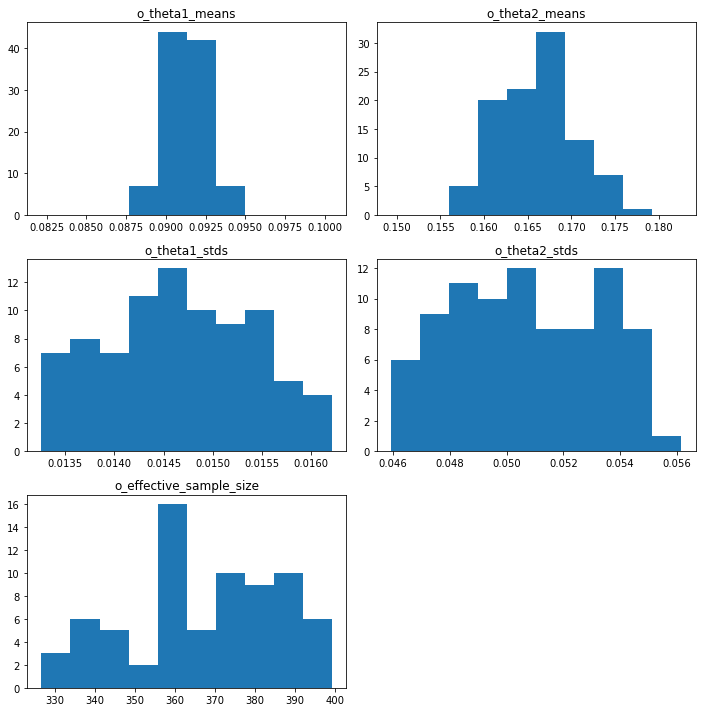

In [16]:
fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata_ori[i], bins = 10, range=(0.9*alldata_ori[i].mean(), 1.1*alldata_ori[i].mean()))
    ax.set_title(allnames_ori[i])
    
fig.tight_layout()

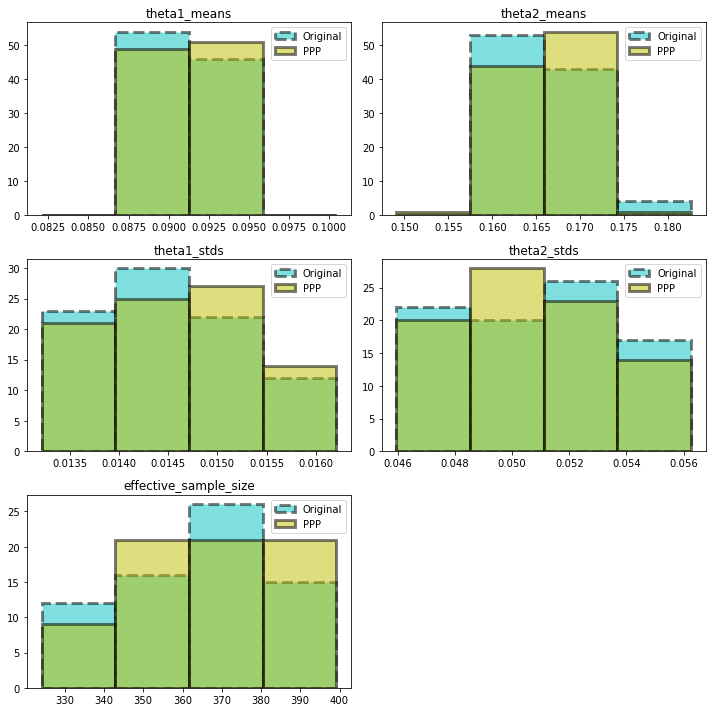

In [17]:
fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(allnames[i])

    lbound=0.9*min(alldata[i].mean(),alldata_ori[i].mean())
    ubound=1.1*max(alldata[i].mean(),alldata_ori[i].mean())

    # plot the histograms as usual
    bins = 20
    ax.hist(alldata[i], bins = bins, range = (lbound, ubound), color = 'c', edgecolor='black', ls='dashed', lw=3, label= "Original", alpha = 0.5)
    ax.hist(alldata_ori[i], bins = bins, range = (lbound, ubound), color = 'y', edgecolor='black', lw=3, label="PPP", alpha = 0.5)
    """
    countsboth=np.zeros(bins)
    vals=np.linspace(lbound, ubound, bins)
    bothdata=[]
    for j in range(bins):
        countsboth[j]=(min(counts1[j],counts2[j]))
        for k in range(int(countsboth[j])):
            bothdata.append(vals[j])
            
    counts3, edges3, bars3 = ax.hist(bothdata, range=(lbound, ubound), color = 'grey', label="both")
    
    minorder=0
    for b1 in bars1:
        if b1.get_zorder()>minorder:
            minorder = b1.get_zorder()
    for b2 in bars2:
        if b2.get_zorder()>minorder:
            minorder = b2.get_zorder()
    
    for b3 in bars3:
        b3.set_zorder(minorder+1)
    """
    ax.legend()
fig.tight_layout()
fig.savefig("/home/felipe/MTGraphics/MeansIEcomparision.jpg")

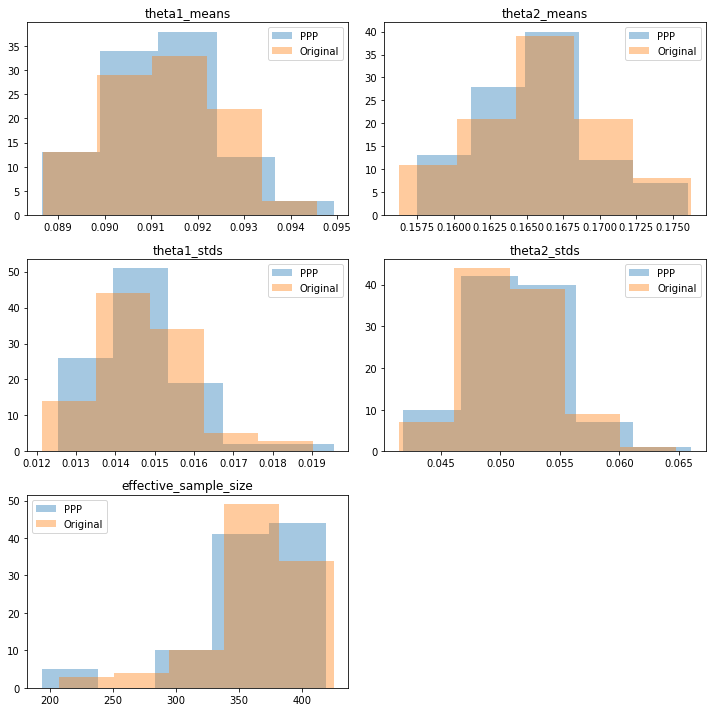

In [18]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(allnames[i])

    bins=10
    sns.distplot(alldata[i], ax = ax, bins = bins, kde=False, label="PPP")
    sns.distplot(alldata_ori[i], ax = ax, bins = bins, kde=False, label="Original")
    ax.legend()
    
fig.tight_layout()


In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(allnames[i])

    bins=20
    sns.distplot(alldata[i], ax = ax, bins = bins, kde=False, label="PPP")
    sns.distplot(alldata_ori[i], ax = ax, bins = bins, kde=False, label="Original")
    ax.legend()
    
fig.tight_layout()
